## 5.1. abundances barplot

In this Notebook we will compare the abundances of each cluster in the different response timepoints (3h, 24h, 72h) to the abundance of that same cluster in the control subset. Since each subset consists of four replicates (defined by the hashtags), we can include an error margin. 

In [1]:
### loading python libraries

# standard libraries
import numpy as np
import pandas as pd

# single cell libraries
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 0

# other 
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore') #ignore filter warnings
plt.rcParams['pdf.fonttype'] = 42 #for saving PDF with changeable text
plt.rcParams['ps.fonttype'] = 42 #for saving PDF with changeable text

### Load dataset

Here, we load the filtered HSPC dataset (as filtered in notebook 1.3).

In [2]:
### load Anndata object with the HSPC dataset (all four subsets incl.)
adata_path = "../data/count_matrices/all_filtered.h5ad"
adata = sc.read_h5ad(adata_path)

### Calculate abundances
Here, we calculate the abundance of each cluster in each timepoint. We calculate the abundance for every hashtag, and the total abundance is the average of the four different hashtags.

In [3]:
### get timepoints and hashtags
timepoints = adata.obs['time'].cat.categories
hashtags = adata.obs['hashtags'].cat.categories

In [4]:
mean_abundances = []
std_abundances = []

### get abundance of each tag, in each timepoint, for each cluster
for i in range(len(timepoints)):
    abund_per_tag = []

    for tag in hashtags:
        abund_tag = pd.DataFrame(adata[(adata.obs["hashtags"]==tag)&(adata.obs["time"]==timepoints[i])].obs["clusters"].value_counts())
        abund_tag = abund_tag.set_index(abund_tag.index.astype("str"))
        abund_per_tag.append(abund_tag)

    abund_per_tag = pd.concat(abund_per_tag, axis=1)
    abund_per_tag.columns = hashtags
    total_cells = pd.DataFrame(abund_per_tag.sum()).transpose()
    abund_per_tag = abund_per_tag/total_cells.loc[0]*100
    abund_per_tag = abund_per_tag.fillna(0) #replace nans with 0
    
    abund_mean = abund_per_tag.mean(axis=1)
    abund_std = abund_per_tag.std(axis=1)
    
    mean_abundances.append(abund_mean)
    std_abundances.append(abund_std)

### make dataframe of the mean abundances
mean_abundances = pd.concat(mean_abundances, axis=1)
mean_abundances.columns = timepoints
mean_abundances = mean_abundances.loc[adata.obs['clusters'].cat.categories,]

### make dataframe of standard deviations
std_abundances = pd.concat(std_abundances, axis=1)
std_abundances.columns = timepoints
std_abundances = std_abundances.loc[adata.obs['clusters'].cat.categories,]

### Plot abundances
Here, we plot the abundances that we retrieved above.

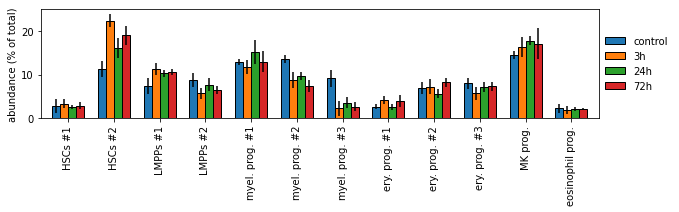

In [5]:
### plot abundances
fig, axs = plt.subplots(1, 1, figsize=(10,2))

mean_abundances.plot(kind="bar", yerr=std_abundances, ax=axs, width=0.7, edgecolor = "black")
axs.grid(False)

# add legend and labels
axs.set_ylabel("abundance (% of total)")
axs.legend(loc="right", bbox_to_anchor=(1.14, 0.5), ncol=1, frameon=False)

# save figure
save_path = "../figures/5.1.abundances_barplot.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)

plt.show()

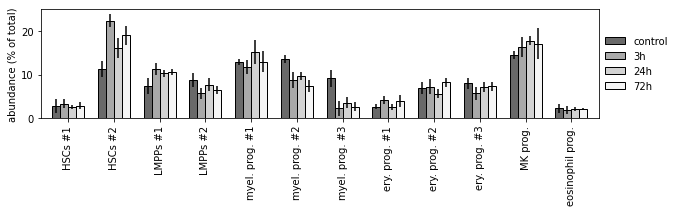

In [6]:
### plot abundances
fig, axs = plt.subplots(1, 1, figsize=(10,2))

mean_abundances.plot(kind="bar", yerr=std_abundances, ax=axs, width=0.7, 
                     color=['dimgray', 'darkgray', 'lightgray', 'whitesmoke'], edgecolor = "black")
axs.grid(False)

# add legend and labels
axs.set_ylabel("abundance (% of total)")
axs.legend(loc="right", bbox_to_anchor=(1.14, 0.5), ncol=1, frameon=False)

# save figure
save_path = "../figures/5.1.abundances_barplot_graytones.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)

plt.show()